# 1. Setup

## 1.1 Install Dependencies

In [3]:
#!pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python matplotlib

## 1.2 Import Dependencies

In [6]:
# Import standard dependencies
import cv2
import os
import time
import random
import numpy as np
from matplotlib import pyplot as plt

In [7]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten, Dropout, Concatenate
import tensorflow as tf

## 1.3 Set GPU Growth

In [6]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
print(tf.config.experimental.list_physical_devices())
#for gpu in gpus: 
   # tf.config.experimental.set_memory_growth(gpu, True)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


2022-07-01 18:26:04.818893: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set


## 1.4 Create Folder Structures

In [7]:
# Setup paths
POS_PATH = os.path.join('..', 'data', 'positive')
NEG_PATH = os.path.join('..', 'data', 'negative')
ANC_PATH = os.path.join('..', 'data', 'anchor')

In [8]:
# Make the directories
os.makedirs(POS_PATH, exist_ok=True)
os.makedirs(NEG_PATH, exist_ok=True)
os.makedirs(ANC_PATH, exist_ok=True)

# 2. Collect Positives and Anchors

## 2.1 Untar Labelled Faces in the Wild Dataset

In [9]:
# http://vis-www.cs.umass.edu/lfw/

In [10]:
# Uncompress Tar GZ Labelled Faces in the Wild Dataset
#!tar -xf lfw.tgz

In [11]:
# # Move LFW Images to the following repository data/negative
# for directory in os.listdir('lfw'):
#     for file in os.listdir(os.path.join('lfw', directory)):
#         EX_PATH = os.path.join('lfw', directory, file)
#         NEW_PATH = os.path.join(NEG_PATH, file)
#         os.replace(EX_PATH, NEW_PATH)


## 2.2 Collect Positive and Anchor Classes

In [12]:
# os.system('python capture.py')

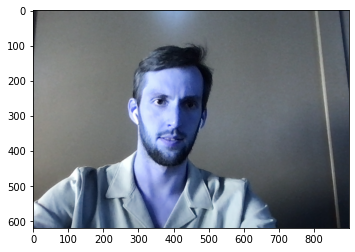

In [13]:
plt.imshow(np.load('../test_images/last_frame.npy'))

# 2.x NEW - Data Augmentation

In [14]:
def data_aug(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        # img = tf.image.stateless_random_crop(img, size=(20,20,3), seed=(1,2))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))
            
        data.append(img)
    
    return data

In [15]:
import os
import uuid

In [16]:
# for file_name in os.listdir(os.path.join(NEG_PATH)):
#     img_path = os.path.join(NEG_PATH, file_name)
#     img = cv2.imread(img_path)
#     augmented_images = data_aug(img)

#     for image in augmented_images:
#         cv2.imwrite(os.path.join(NEG_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [17]:
# for file_name in os.listdir(os.path.join(ANC_PATH)):
#     img_path = os.path.join(ANC_PATH, file_name)
#     img = cv2.imread(img_path)
#     augmented_images = data_aug(img)

#     for image in augmented_images:
#         cv2.imwrite(os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [18]:
# for file_name in os.listdir(os.path.join(POS_PATH)):
#     img_path = os.path.join(POS_PATH, file_name)
#     img = cv2.imread(img_path)
#     augmented_images = data_aug(img) 
    
#     for image in augmented_images:
#         cv2.imwrite(os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

# 3. Load and Preprocess Images

## 3.1 Get Image Directories

In [34]:
take_n = 1000

anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(take_n)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(take_n)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(take_n)

In [35]:
dir_test = anchor.as_numpy_iterator()

In [36]:
print(dir_test.next())

b'../data/anchor/a6e5a7d0-f981-11ec-9d7a-acde48001122.jpg'


## 3.2 Preprocessing - Scale and Resize

In [37]:
IMG_SIZE = 900

In [38]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (IMG_SIZE,IMG_SIZE))
    # Scale image to be between 0 and 1 
    img = img / 255.0

    # Return image
    return img

## 3.3 Create Labelled Dataset

In [39]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [40]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [41]:
samples = data.as_numpy_iterator() 
exampple = samples.next() 
exampple

(b'../data/anchor/794bea86-f982-11ec-b2be-acde48001122.jpg',
 b'../data/positive/f2e12b04-f982-11ec-b2be-acde48001122.jpg',
 1.0)

## 3.4 Build Train and Test Partition

In [42]:
def preprocess_twin(input_img, validation_img, label):
    
    return(preprocess(input_img), preprocess(validation_img), label)

In [43]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [44]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [45]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# 4. Model Engineering

## 4.1 Build Embedding Layer

In [46]:
def make_embedding():
    inp = Input(shape=(IMG_SIZE,IMG_SIZE,3), name='input_image')
    
    # first block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(pool_size=(8,8), padding='same')(c1)
    dr1 = Dropout(0.3)(m1)
    c1_flat = Flatten()(dr1)

    # second block
    c2 = Conv2D(128, (7,7), activation='relu')(dr1)
    m2 = MaxPooling2D(pool_size=(6,6), padding='same')(c2)
    dr2 = Dropout(0.3)(m2)


    # third block
    c3 = Conv2D(128, (4,4), activation='relu')(dr2)
    m3 = MaxPooling2D(pool_size=(2,2), padding='same')(c3)
    dr3 = Dropout(0.3)(m3)


    # final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(dr3)
    f1 = Flatten()(c4)
    #combined = Concatenate()([f1, c1_flat])
    d1 = Dense(2048, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(l=.01))(f1)

    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [47]:
embedding = make_embedding()
embedding.summary()

Model: "embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 900, 900, 3)]     0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 891, 891, 64)      19264     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 106, 106, 128)     401536    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 18, 18, 128)       0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 18, 18, 128)       0 

## 4.2 Build Distance Layer

In [48]:
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__()

    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

## 4.3 Make Siamese Model

In [49]:
def make_siamese_model():
    
    # Anchor image input in the network
    input_img = Input(name='input_img', shape=(IMG_SIZE,IMG_SIZE,3))

    # Validation image in the network
    validation_img = Input(name='validation_img', shape=(IMG_SIZE,IMG_SIZE,3))

    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_img), embedding(validation_img))

    # Classification layer

    classifier = Dense(1, activation = 'sigmoid')(distances)

    return Model(inputs=[input_img, validation_img], outputs=classifier, name = 'SiameseNetwork')
    

In [50]:
siamese_model = make_siamese_model()
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 900, 900, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 900, 900, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 2048)         14316864    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
distance (L1Dist)               (None, 2048)         0           embedding[0][0]     

# 5. Training

## 5.1 Setup Loss and Optimizer

In [51]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [52]:
opt = tf.keras.optimizers.Adam(learning_rate = .0001)

## 5.2 Establish Checkpoints

In [53]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

## 5.3 Build Train Step Function

In [54]:
@tf.function
def train_step(batch):

# Record operations for automatic differentiation
    with tf.GradientTape() as tape:
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get Label
        y = batch[2]

        # Forward pass
        yhat = siamese_model(X, training = True)

        # Calculate loss
        loss = binary_cross_loss(y, yhat)

    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)

    # Calculate update weights and apply to siamese models
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))

    return loss


## 5.4 Build Training Loop

In [55]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [56]:
def train(data, epochs):
    # Loop over epochs
    losses = []
    for epoch in range(1, epochs + 1):
        print('Epoch {}/{}'.format(epoch, epochs))
        progbar = tf.keras.utils.Progbar(len(data))
        
        start = time.time()  # record start time
        
        # Loop over batches
        for idx, batch in enumerate(data):
            loss = train_step(batch)
            losses.append(loss)
            progbar.update(idx+1)

        end = time.time() # record end time
    
        print('Epoch {} Loss {:.4f} Time {:.4f}'.format(epoch, loss, end - start))
        if epoch % 10 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
    
    return losses


## 5.5 Train the model

In [57]:
EPOCHS = 30
losses = train(train_data, EPOCHS)

Epoch 1/30


2022-07-01 18:26:41.710777: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-07-01 18:26:51.718773: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 644 of 1024
2022-07-01 18:26:57.902312: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


88/88 [==============================] - 5013s 57s/step
Epoch 1 Loss 0.6411 Time 5013.3002
Epoch 2/30
44/88 [==============>...............] - ETA: 6:37:35

KeyboardInterrupt: 

# 6. Evaluate Model

## 6.1 Import Metrics

In [ ]:
# Import metric calculation functions
from tensorflow.keras.metrics import Precision, Recall

## 6.2 Make Predictions

In [ ]:
# Get a batch of test data
batches = test_data.as_numpy_iterator()

In [ ]:
test_input, test_val, y_true = batches.next()

In [ ]:
# Make predictions 
yhat = siamese_model.predict([test_input, test_val])
yhat

array([[2.0949006e-02],
       [5.3075820e-02],
       [1.0800141e-01],
       [5.0572985e-01],
       [1.4472997e-01],
       [1.9183218e-02],
       [5.1183385e-01],
       [5.0058734e-01],
       [8.2511902e-03],
       [1.2031198e-02],
       [1.1516020e-01],
       [5.0182623e-01],
       [4.9761713e-01],
       [5.0456131e-01],
       [4.0924549e-04],
       [2.4159163e-02]], dtype=float32)

In [ ]:
# Post processing the results
[1 if prediction > 0.5 else 0 for prediction in yhat]

[0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0]

## 6.3 Calculate Metrics

In [ ]:
# Create a metric object
r = Recall()
p = Precision()

# Calculating recall value
r.update_state(y_true, yhat)
p.update_state(y_true, yhat)

# Return recall value
print('recall: ', r.result().numpy())
print('precision: ', p.result().numpy())


recall:  0.8333333
precision:  1.0


## 6.4 Viz Results

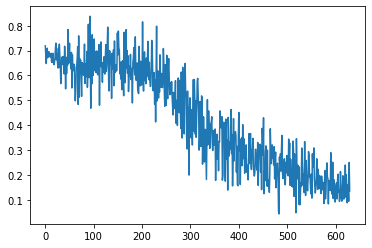

In [ ]:
plt.plot(losses)

1.0


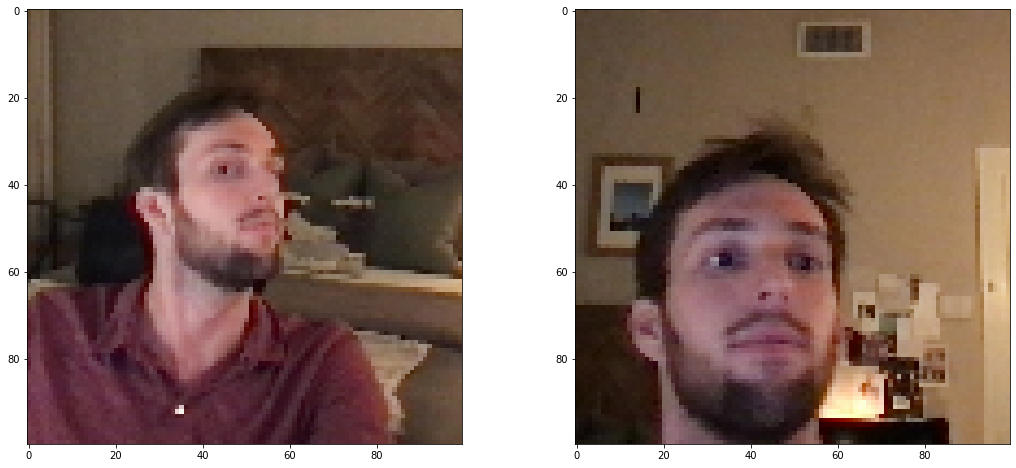

In [ ]:
plt_img = 6
print(y_true[plt_img])

plt.figure(figsize=(18,8))
plt.subplot(1,2,1)
plt.imshow(test_input[plt_img])
plt.subplot(1,2,2)
plt.imshow(test_val[plt_img])
plt.show()


# 7. Save Model

In [ ]:
# Save weights
siamese_model.save('siamesemodelv2.h5')

In [ ]:
# Reload model 
siamese_model = tf.keras.models.load_model('siamesemodelv2.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [ ]:
# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])

array([[0.28010166],
       [0.02227718],
       [0.50572985],
       [0.0253374 ],
       [0.03786343],
       [0.5080352 ],
       [0.24922138],
       [0.4942108 ],
       [0.00061071],
       [0.35606727],
       [0.00398624],
       [0.09509099],
       [0.00127333],
       [0.0064044 ],
       [0.08746627],
       [0.516981  ]], dtype=float32)

In [ ]:
# View model summary
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
l1_dist_1 (L1Dist)              (None, 4096)         0           embedding[0][0]     

# 8. Real Time Test

## 8.1 Verification Function

In [60]:
# def verify(frame, model, detection_threshold):

#     # Build results array
#     results = []
#     for image in os.listdir(os.path.join('..','application_data', 'verification_images')):
#         input_img = preprocess(os.path.join('..','application_data', 'input_image', 'input_image.jpg'))
#         validation_img = preprocess(os.path.join('..','application_data', 'verification_images', image))

#         # Make predictions
#         result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
#         results.append(result)

#     detection = np.sum(np.array(results) > detection_threshold)
#     verification = detection / len(os.listdir(os.path.join('..','application_data', 'verification_images')))
#     verified = verification > detection_threshold

#     return results, verified

#     # Metric above which a prediction is considered a match
#     # Verification Threshold: Proporation of positive predictions / total predictions


## 8.2 OpenCV Real Time Verification

In [3]:
os.chdir('/Users/cole.harrison/Desktop/jcoleharrison/facial_recognition')
os.system('python src/real_time_test.py')

2022-07-02 19:26:33.412311: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-07-02 19:26:33.412487: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-02 19:26:54.673009: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


0.27094608804453973
0.37340520775836444
0.14073685977769934
0.7277641296386719
0.6213707301927649
0.760125035824983
0.7287282529084579


0

In [35]:
# load in losses 
import pickle

with open('loss', 'rb') as file:
    losses = pickle.load(file)

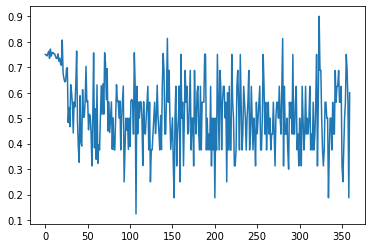

In [36]:
from matplotlib import pyplot as plt
plt.plot(losses)